In [2]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import skimage

print(f"scikit-image version: {skimage.__version__}")

def load_and_preprocess(folder, label, img_size=(64, 64)):
    data = []
    labels = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)  
        if img is None:
            print(f"Skipping corrupted file: {img_path}")
            continue  
        img = cv2.resize(img, img_size)

        try:
            features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                            channel_axis=-1, visualize=True)  # Use channel_axis for newer versions
        except TypeError:
            # Fallback: Convert to grayscale if multichannel fails
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            features, _ = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        
        data.append(features)
        labels.append(label)  # 0 for cat, 1 for dog
    return np.array(data), np.array(labels)

# Load and preprocess training data
train_cats_data, train_cats_labels = load_and_preprocess("C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/train2/cats", 0)
train_dogs_data, train_dogs_labels = load_and_preprocess("C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/train2/dogs", 1)
X_train = np.vstack((train_cats_data, train_dogs_data))
y_train = np.hstack((train_cats_labels, train_dogs_labels))

# Load and preprocess validation data
val_cats_data, val_cats_labels = load_and_preprocess("C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/validation/cats", 0)
val_dogs_data, val_dogs_labels = load_and_preprocess("C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/validation/dogs", 1)
X_val = np.vstack((val_cats_data, val_dogs_data))
y_val = np.hstack((val_cats_labels, val_dogs_labels))

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=300)  # Adjust based on variance
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# After fitting scaler and pca
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Save the fitted scaler and pca
os.makedirs('C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog', exist_ok=True)
joblib.dump(scaler, 'C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/scaler.pkl')
joblib.dump(pca, 'C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/pca.pkl')
np.save('C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/X_train_pca.npy', X_train_pca)
np.save('C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/y_train.npy', y_train)
np.save('C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/X_val_pca.npy', X_val_pca)
np.save('C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/y_val.npy', y_val)

print(f"PCA variance retained: {np.sum(pca.explained_variance_ratio_):.4f}")

scikit-image version: 0.25.2
PCA variance retained: 0.8154


In [7]:
import os
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import joblib
import numpy as np


X_train_pca = np.load("C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/X_train_pca.npy")
y_train = np.load("C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/y_train.npy")
X_val_pca = np.load("C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/X_val_pca.npy")
y_val = np.load("C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/y_val.npy")

# Create models directory
os.makedirs('models', exist_ok=True)

# Define parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10],  # Smaller C to reduce overfitting
    'gamma': ['scale', 'auto', 0.001]  # Try different kernel coefficients
}
svm = SVC(kernel='rbf', random_state=42)
grid = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1)  # Use all CPU cores
grid.fit(X_train_pca, y_train)

# Best model
svm_model = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}, Best cross-val score: {grid.best_score_:.4f}")

# Save the model
joblib.dump(svm_model, 'models/svm_model_tuned.pkl')

# Evaluate on train and validation
train_pred = svm_model.predict(X_train_pca)
val_pred = svm_model.predict(X_val_pca)
print(f"Train Accuracy: {accuracy_score(y_train, train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, val_pred):.4f}")

Best parameters: {'C': 10, 'gamma': 0.001}, Best cross-val score: 0.7861
Train Accuracy: 1.0000
Validation Accuracy: 0.7936


In [8]:
joblib.dump(svm_model, 'models/svm_model_tuned.pkl')
print(f"Model saved to: {os.path.abspath('models/svm_model_tuned.pkl')}")

Model saved to: C:\Users\Yuvraj\models\svm_model_tuned.pkl


Predicted class: Dog
Decision function value: 1.3383


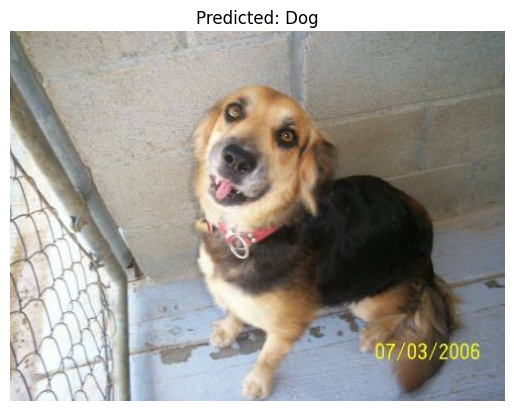

In [4]:
import os
import cv2
import numpy as np
from skimage.feature import hog
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the saved model
svm_model = joblib.load("C:/Users/Yuvraj/Downloads/models/svm_model_tuned.pkl")

# Load the fitted scaler and PCA objects
scaler = joblib.load('C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/scaler.pkl')
pca = joblib.load('C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/pca.pkl')

# Function to preprocess a single image (match training pipeline)
def preprocess_single_image(img_path, img_size=(64, 64)):
    # Read image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image at {img_path}")
    img = cv2.resize(img, img_size)
    
    # Extract HOG features (match the training setup)
    try:
        features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                         channel_axis=-1, visualize=True)
    except TypeError:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features, _ = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    
    # Reshape for scaler
    features = features.reshape(1, -1)
    
    # Apply the fitted scaler and PCA
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    return features_pca

# Path to your real image
real_image_path = "C:/Users/Yuvraj/OneDrive/Desktop/dataset/cat_and_dog/validation/dogs/dog.6440.jpg"

# Preprocess and predict
class_name = None  # Initialize to avoid NameError
try:
    X_real_pca = preprocess_single_image(real_image_path)
    
    # Make prediction
    prediction = svm_model.predict(X_real_pca)
    class_name = "Dog" if prediction[0] == 1 else "Cat"
    probability = svm_model.decision_function(X_real_pca)[0]
    
    print(f"Predicted class: {class_name}")
    print(f"Decision function value: {probability:.4f}")

    # Visualize the image with prediction
    img = cv2.imread(real_image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Predicted: {class_name}")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error: {e}")